__EDA__

In [108]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

train_df = pd.read_csv("../data/train.csv", index_col='PassengerId')
test_df = pd.read_csv("../data/test.csv", index_col='PassengerId')
train_df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [109]:
train_df['title'] = train_df['Name'].str.split(',|\\.',expand = True)[1]
train_df['title'] = train_df['title'].str.strip()
status_map={'Capt':'Military',
            'Col':'Military',
            'Don':'Noble',
            'Dona':'Noble',
            'Dr':'Dr',
            'Jonkheer':'Noble',
            'Lady':'Noble',
            'Major':'Military',
            'Master':'Common',
            'Miss':'Common',
            'Mlle':'Common',
            'Mme':'Common',
            'Mr':'Common',
            'Mrs':'Common',
            'Ms':'Common',
            'Rev':'Clergy',
            'Sir':'Noble',
            'the Countess':'Noble',
            }
# Creating the social status field based on Name - Title
train_df['SocialStatus'] = train_df['title'].map(status_map)

train_df['Title'] = train_df.Name.str.extract('([A-Za-z]+)\.')
train_df['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)


In [110]:
# Filling missing values in Age using Title
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Mr'),'Age']= train_df.Age[train_df.Title=="Mr"].mean()
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Mrs'),'Age']= train_df.Age[train_df.Title=="Mrs"].mean()
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Master'),'Age']= train_df.Age[train_df.Title=="Master"].mean()
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Miss'),'Age']= train_df.Age[train_df.Title=="Miss"].mean()
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Other'),'Age']= train_df.Age[train_df.Title=="Other"].mean()

train_df['Cabin'] = train_df['Cabin'].fillna('Z')
train_df['CabinLetter'] = train_df['Cabin'].apply(lambda x: x[0])

train_df["Fare"].fillna(train_df.groupby("Pclass")["Fare"].transform("mean"), inplace=True)
train_df["Embarked"].fillna('S', inplace=True)

# New features
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1

# Droping unnecessary features
train_df = train_df.drop(['SibSp', 'Parch', 'Name', 'Title', 'title', 'Ticket', 'Cabin'], axis=1)
train_df = train_df.reset_index(drop=True)
train_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,SocialStatus,CabinLetter,FamilySize,IsAlone
0,0,3,male,22.0,7.2500,S,Common,Z,2,0
1,1,1,female,38.0,71.2833,C,Common,C,2,0
2,1,3,female,26.0,7.9250,S,Common,Z,1,1
3,1,1,female,35.0,53.1000,S,Common,C,2,0
4,0,3,male,35.0,8.0500,S,Common,Z,1,1


In [111]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df

,index,0
0,Survived,0
1,Pclass,0
2,Sex,0
3,Age,0
4,Fare,0
5,Embarked,0
6,SocialStatus,0
7,CabinLetter,0
8,FamilySize,0
9,IsAlone,0


In [112]:
non_numeric_features = ['Embarked', 'Sex', 'CabinLetter', 'SocialStatus', 'FamilySize', 'Age', 'Fare']

for feature in non_numeric_features:        
    train_df[feature] = LabelEncoder().fit_transform(train_df[feature])

train_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,SocialStatus,CabinLetter,FamilySize,IsAlone
0,0,3,1,30,18,2,1,8,1,0
1,1,1,0,55,207,0,1,2,1,0
2,1,3,0,36,41,2,1,8,0,1
3,1,1,0,50,189,2,1,2,1,0
4,0,3,1,50,43,2,1,8,0,1


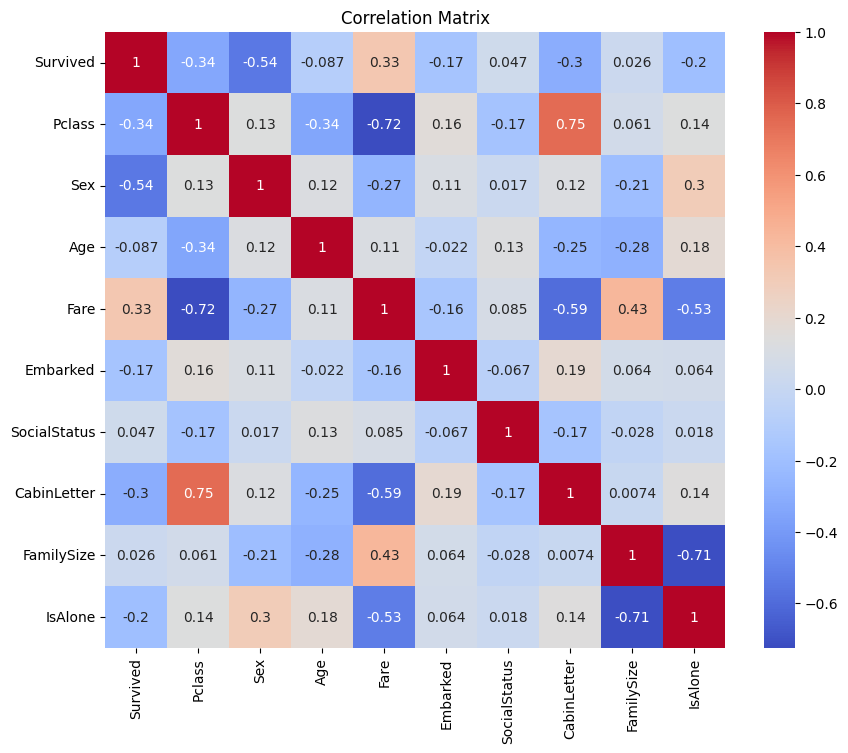

Selected Features based on Correlation:


Index(['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'CabinLetter',
       'IsAlone'],
      dtype='object')

In [113]:
corr_matrix = train_df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Set a correlation threshold for feature selection
corr_threshold = 0.1

# Select features based on correlation with the target variable (Survived)
selected_features = corr_matrix['Survived'][abs(corr_matrix['Survived']) > corr_threshold].index

# Print the selected features
print("Selected Features based on Correlation:")
selected_features